# Active Learning (AL)

**TL;DR**  

In this notebook, we provide a tutorial on **active learning (AL)** in the context of emulators and simulators. **Active learning** is a strategy where an **emulator** selectively queries a computationally expensive **simulator** for labels, improving prediction accuracy while minimizing simulation costs. We introduce different AL settings—**stream-based, pool-based, and membership query learning**—but focus primarily on the **stream-based setting**, where data arrives sequentially, and the emulator must decide in real-time whether to query the simulator.

To formalize this, we define a class hierarchy for **learners**, which can be visualized using `base.Learner.plot_hierarchy()`: 

```code
Learner [Concrete]
└── Active [Abstract]
    ├── Pool [Abstract]
    ├── Membership [Abstract]
    └── Stream [Abstract]
        ├── Random [Concrete]
        └── Threshold [Abstract]
            ├── Input [Abstract]
            │   └── Distance [Concrete]
            │       └── Adaptive_Distance [Concrete]
            └── Output [Abstract]
                ├── A_Optimal [Concrete]
                │   └── Adaptive_A_Optimal [Concrete]
                ├── D_Optimal [Concrete]
                │   └── Adaptive_D_Optimal [Concrete]
                └── E_Optimal [Concrete]
                    └── Adaptive_E_Optimal [Concrete]
```

This structure captures different querying strategies for active learners:
- **`Random`** queries the simulator with a fixed probability.
- **`Threshold`**-based learners decide based on a computed score, such as **uncertainty** (model confidence) or **diversity** (novelty of the input).
- **`Adaptive`** learners dynamically adjust their threshold using **Proportional-Integral-Derivative (PID) control** to maintain a target query rate.

Through this hierarchy, we systematically implement and compare different active learning strategies in the **stream-based setting**.

Let's import what we need and also plot the hierarchy for active learners.

In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from typing import List, Dict, Tuple, Iterable
from dataclasses import asdict

# Import core classes from the source code.
from autoemulate.experimental.learners import Emulator, Simulator, pool, membership, stream, base
from autoemulate.simulations.projectile import simulate_projectile_multioutput
from autoemulate.emulators import GaussianProcess
from autoemulate.experimental_design import LatinHypercube

base.Active.plot_hierarchy()

Active [Abstract]
├── Pool [Abstract]
├── Membership [Abstract]
└── Stream [Abstract]
    ├── Random [Concrete]
    └── Threshold [Abstract]
        ├── Input [Abstract]
        │   └── Distance [Concrete]
        │       └── Adaptive_Distance [Concrete]
        └── Output [Abstract]
            ├── A_Optimal [Concrete]
            │   └── Adaptive_A_Optimal [Concrete]
            ├── D_Optimal [Concrete]
            │   └── Adaptive_D_Optimal [Concrete]
            └── E_Optimal [Concrete]
                └── Adaptive_E_Optimal [Concrete]


## Overview of AL

In AutoEmulate, we use **inexpensive** emulator models to approximate **expensive** simulations. However, these emulators require training data from the simulator. Therefore, a critical challenge is deciding which input points to query from the simulator to optimize the emulator's performance while minimizing simulation costs. Fundamentally, we can view both the simulator and emulator as functions that map from an input space $ \mathcal{X}$ (independent variables) to an output space $ \mathcal{Y}$ (dependent variables):
$$
\mathrm{Simulator}: \mathcal{X} \to \mathcal{Y} \qquad \text{and} \qquad \mathrm{Emulator}: \mathcal{X} \to \mathcal{Y}.
$$

In practice, our primary goal is to provide reliable predictions with the emulator. When the emulator is too uncertain about a user's query, we query the simulator to obtain a more accurate output and then update the emulator accordingly. This scenario is naturally addressed using a **stream-based** active learning approach: as inputs arrive sequentially, we decide whether to rely on the emulator or to query the simulator based on the emulator's uncertainty.

For context, AL strategies can be categorized into three main scenarios:

| **Active Learning Strategy** | **Candidate Set** | **Query Output** | **Query Method Signature** | **Description** |
|------------------------------|-------------------|------------------|----------------------------|-----------------|
| **Membership-Based**         | Any candidate subset $S \subseteq \mathcal{X}$ (where $\mathcal{X}$ is the entire continuous input space) | A single query point $x \in S$ | $q: \mathcal{P}(\mathcal{X}) \to \mathcal{X}$, with $q(S) \in S$ | The learner synthesizes queries by selecting an informative point from a candidate subset of the entire space. Here, $\mathcal{P}(\mathcal{X})$ is the powerset of $\mathcal{X}$ (i.e. the set of all subsets of $\mathcal{X}$). |
| **Pool-Based**               | Any candidate subset $S \subseteq \hat{\mathcal{X}}$ (where $\hat{\mathcal{X}} \subseteq \mathcal{X}$ is a fixed, finite pool) | A single query point $x \in S$ | $q: \mathcal{P}(\hat{\mathcal{X}}) \to \hat{\mathcal{X}}$, with $q(S) \in S$ | The learner selects an informative point from a fixed pool of unlabeled data. Here, $\mathcal{P}(\hat{\mathcal{X}})$ denotes the powerset of the fixed pool. |
| **Stream-Based**             | Individual inputs $x \in \mathcal{X}$ arriving sequentially | A binary decision $d \in \{0,1\}$ (to label or skip) | $q: \mathcal{X} \to \{0,1\}$ | The learner processes each incoming input and decides in real time whether to query its label. This approach is particularly useful when we want to query the simulator only when the emulator's prediction is uncertain. |

To formalise, we can make the following API for active learning in general, where there are three main components:

`Simulator`: 
- `sample` supplies us with output labels given inputs.
- `sample_forward` is the method you override to enable the `sample` method.
- For convenience, we also add on a `sample_inputs` method to sample the input space $\mathcal{X}$ of the simulator.

`Emulator`: 
- `sample`: supplies us with output predictions (mean and uncertainty) given inputs.
- `fit_forward` is the method you overide to fit your emulator to data.
- `sample_forward` is the method you override to enable the `sample` method.

`Learner`: 
- Uses `Emulator` to determine where to query `Simulator` to improve `Emulator`.
- `query`: a method with any of the query signatures given in the table above. This is the only thing that needs to be define by the user. It must return a tuple `X, Y, Sigma, dict(...)`, where 
  1. `X` is either a point or batch of points to be queried, or `None` meaning that we should not sample in this iteration.
  2. `Y` the emulator's prediction of the output.
  3. `Sigma` the covariance of the emulator's prediction, which can either correspond to a scalar isotropic covariance matrix with a shape of `(batch_size,)`, a diagonal covariance matrix with a shape of `(batch_size, n_dim)` where `n_dim` is the spatial dimension, or a full covariance matrix with a shape of `(batch_size, n_dim, n_dim)`.
  4. `dict(key=scalar)` a dictionary of scalars **specific** to the learner subclass, which the **basic** metrics dict (mentioned below) is updated with.
- `fit`: calls the query method, and based on its response, calls the simulator, updates the training set, and refits the emulator.
- `metrics`: a dictionary of metrics recorded during the active learning process. **Basic** metrics are recorded by default -- `'mse', 'r2', 'rate', 'n_queries', 'logdet', 'trace', 'max_eigval'`. The last three metrics are scalar measures of uncertainty computed from the covariance returned from `query`.


## Stream-based AL methods

**Random sampling** (`stream.Random`)

Random sampling is one of the simplest forms of stream-based active learning. Rather than selectively querying the most informative samples, this method queries the simulator at a constant probability, which results in a steady query rate equal to that probability. Although it doesn't adapt based on uncertainty or diversity, it serves as a useful baseline for comparison with more sophisticated methods.

**Threshold-based sampling** (`stream.Threshold`)

Another popular strategy in stream-based active learning is to query the simulator whenever a particular metric exceeds a predefined threshold. For example, one might query the simulator when the emulator's uncertainty (standard deviation) surpasses a certain value, or when the input is sufficiently novel compared to previously seen data points. 

To generalize this, we implement the abstract `Threshold` class. Subclasses must define the `score` method, which returns a numeric measure used to decide whether to query (by comparison with the threshold).

This design allows flexible implementation of threshold-based querying strategies, enabling subclasses to define their own scoring mechanisms and corresponding thresholds.

**Uncertainty Threshold** (`stream.{A, E, D}-Optimal`)

A common threshold-based approach is to query the simulator whenever the emulator's uncertainty exceeds a predefined threshold. In this simple method, the computed **score** used for decision-making is directly equal to the emulator's **uncertainty**. Thus, querying occurs precisely when the emulator is uncertain enough about its predictions. We implement three measures of uncertainty based on the covariance returns by `query`.
1. `stream.A_Optimal`: based on trace of covariance matrix.
2. `stream.E_Optimal`: based on log determinant of covariance matrix.
3. `stream.D_Optimal`: baesd on maximum eigenvalue of covariance matrix.

**Distance Threshold** (`stream.Distance`)

Another example of a threshold-based approach is **diversity querying**, where we query the simulator if the input sample is sufficiently different from previously observed training samples. Specifically, we compute the minimum distance between the new input and all inputs in the current training set and query the simulator if this distance exceeds a predefined threshold. This strategy explicitly encourages the learner to **explore and cover** the input space.

> Note that **Uncertainty Threshold** method implemented here react to measurments on the output space $(\mathcal{Y}, \Sigma)$ of the simulator/emulator, while the **Distance Threshold** method operates on the inputs space $\mathcal{X}$.

**Adaptive Threshold (PID Control)** (e.g. `stream.Adaptive_E_Optimal`)

In the above threshold methods, the threshold was constant. Intuitively, this results in the query rate (`learner.metrics['rates']`) eventually decaying to zero, because the emulator's uncertainty or input distance typically decreases as more data is collected. However, a constant threshold doesn't consider practical constraints—such as a computational budget limiting the total number of queries we can afford to the simulator.

To address this, we can specify a target query rate (`target_rate`) and adaptively adjust the threshold to maintain this target. This transforms the active learning problem into a **feedback control problem**, with:

- The **threshold** as the control input.
- The **query rate** (`rates`) as the measured system output.
- The **desired query rate** (`target_rate`) as the setpoint.

We implement this feedback mechanism using a [**Proportional-Integral-Derivative (PID)**](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller) controller, given by the discrete-time control equation:

$$
u_k = K_p e_k + K_i \sum_{j=0}^{k} e_j + K_d (e_k - e_{k-1}), \quad \text{where} \quad e_k = \mathrm{rate}_k - \mathrm{rate}_{\text{target}}.
$$

The PID controller uses three positive constants to tune behavior:

- **$K_p$**: Proportional gain (responds to immediate error).
- **$K_i$**: Integral gain (addresses cumulative errors over time).
- **$K_d$**: Derivative gain (responds to rate of change of the error).

Since both uncertainty-based and distance-based threshold methods benefit from PID control, we avoid code duplication by implementing this as a [mixin class](https://en.wikipedia.org/wiki/Mixin). Additionally, we introduce `{max,min}_threshold` attributes to impose an upper limit on the adaptive threshold, ensuring the emulator maintains a minimum level of reliability. Finally, we explicitly call this decorator to register the PID-enhanced classes into our learner hierarchy.

## Setting Up a Simple Experiment

In this section we define a simple simulator and an emulator:

- **Simulator:** A subclass that generates sine values.
- **Emulator:** A Gaussian Process emulator that “learns” the sine function.

These are minimal subclasses that use the imported framework classes.

In [2]:
# Define a simple sine simulator.
class Sin(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sin(X)
    def sample_inputs(self, n: int) -> torch.Tensor:
        return torch.Tensor(LatinHypercube([(0., 50.)]).sample(n))

class Projectile(Simulator):
    def sample_forward(self, X: torch.Tensor) -> torch.Tensor:
        return torch.tensor([simulate_projectile_multioutput(x) for x in X])
    def sample_inputs(self, n: int) -> torch.Tensor:
        return torch.Tensor(LatinHypercube([(-5., 1.), (0., 1000.)]).sample(n))

# Define an emulator using a dummy Gaussian Process.
class GP(Emulator):
    def __init__(self):
        self.model = GaussianProcess()
    def fit_forward(self, X: torch.Tensor, Y: torch.Tensor):
        self.model.fit(X, Y)
    def sample_forward(self, X: torch.Tensor):
        return torch.from_numpy(np.array(self.model.predict(X, return_std=True)))

## Instantiating Active Learning Strategies

Here we instantiate several learners with different active learning strategies. Each learner combines a simulator and an emulator, along with its specific query approach. We implement this as an iterator so that we do not instantiate all learners at once, which could be cumbersome on memory.

For example:
- **Random:** Queries samples based on a fixed probability.
- **A‑Optimal, D‑Optimal, E‑Optimal:** Query based on different design criteria.
- **PID‑based learners:** Adapt the query threshold with PID control.

Note that the hyperparameters (e.g. query probability, threshold, PID gains) are provided during instantiation. Note that for each instantiation of this iterator, all active learning class take in the same initial training set.

In [3]:
def learners(*, simulator: Simulator, n_initial_samples: int, adaptive_only: bool) -> Iterable:
    X_train = simulator.sample_inputs(n_initial_samples)
    Y_train = simulator.sample(X_train)
    yield stream.Random(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        p_query=0.25
    )
    if not adaptive_only:
        yield stream.Distance(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=0.5
        )
        yield stream.A_Optimal(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=1.0
        )
        yield stream.D_Optimal(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=-4.2
        )
        yield stream.E_Optimal(
            simulator=simulator, emulator=GP(),
            X_train=X_train, Y_train=Y_train,
            threshold=1.0
        )
    yield stream.Adaptive_Distance(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=0.5, Kp=1.0, Ki=1.0, Kd=1.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=2.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_A_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=1e-1, Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=1.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_D_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=-4.0, Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=-5 if isinstance(simulator, Sin) else None, 
        max_threshold=0 if isinstance(simulator, Sin) else None,
        window_size=10
    )
    yield stream.Adaptive_E_Optimal(
        simulator=simulator, emulator=GP(),
        X_train=X_train, Y_train=Y_train,
        threshold=0.75 if isinstance(simulator, Sin) else 1000, 
        Kp=2.0, Ki=1.0, Kd=2.0,
        key="rate", target=0.25,
        min_threshold=0.0, # if isinstance(simulator, Sin) else None, 
        max_threshold=1.0 if isinstance(simulator, Sin) else None,
        window_size=10
    )

Note that all of these active learning strategies are implemented as dataclasses with visible fields containing most of the arguments needed for reinitialization -- which can be useful for serializing.

In [4]:
for learner in learners(simulator=Sin(), n_initial_samples=10, adaptive_only=False):
    print(asdict(learner))

{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'p_query': 0.25}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': 0.5}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': 1.0}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': -4.2}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': 1.0}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': 0.5, 'Kp': 1.0, 'Ki': 1.0, 'Kd': 1.0, 'key': 'rate', 'target': 0.25, 'min_threshold': 0.0, 'max_threshold': 2.0, 'window_size': 10}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': 0.1, 'Kp': 2.0, 'Ki': 1.0, 'Kd': 2.0, 'key': 'rate', 'target': 0.25, 'min_threshold': 0.0, 'max_threshold': 1.0, 'window_size': 10}
{'simulator': {}, 'emulator': {}, 'in_dim': 1, 'out_dim': 1, 'threshold': -4.0, 'Kp': 2.0, 'Ki': 1.0, 'Kd': 2.0, 'key': 'rate', 'target': 0.25, 'min_threshold': -5, 'max_threshold': 0, 'window_

## Running an Active Learning Experiment

- We simulate a stream of unlabeled data using Latin Hypercube sampling.
Each learner then processes the stream using its own query strategy.
We use a different random seed for each trial.
- After processing, we aggregate the metrics (such as MSE, R2 score, and design criteria) and visualize them.
- The argument `batch_size` determines whether we do the experiment in batch mode or per-sample mode:
    - `batch_size = None` = per-sample mode.
    - `batch_size = n` = batch mode with batch size `n`.

In [5]:
def run_experiment(
    *,
    simulator: Simulator,
    seeds: List[int],
    n_initial_samples: int,
    n_stream_samples: int,
    adaptive_only: bool,
    batch_size: int | None
) -> Tuple[List[Dict], List[Dict]]:
    metrics, summary = list(), list()
    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        X_stream = simulator.sample_inputs(n_stream_samples)
        tqdm.write(f"Trial with seed {seed}")
        for learner in learners(
            simulator=simulator, 
            n_initial_samples=n_initial_samples, 
            adaptive_only=adaptive_only
        ):
            if batch_size is not None:
                learner.fit_batches(X_stream, batch_size)
            else:
                learner.fit_samples(X_stream)
            metrics.append(dict(
                name=learner.__class__.__name__,
                **learner.metrics
            ))
            summary.append(dict(
                name=learner.__class__.__name__,
                **learner.summary
            ))
    return metrics, summary

Here we compute the statistic over the summary metrics supplied by each learner.

In [6]:
def compute_statistics(summary: List[Dict]) -> pd.DataFrame:
    df = pd.DataFrame(summary).groupby('name').agg(['mean', 'std'])
    df = df.sort_values(('mse_per_query', 'mean'), ascending=True).round(6)
    return df

Here we plot all of the running metrics in terms of their mean and standard reviation. We have the following metrics:
1. `'mse'`: mean squared error between the emulator's prediction and the simulator's label before fitting the emulator.
2. `'r2'`: 
    $$
    R^2 = 1 - \frac{\sum (y_{\text{true}} - y_{\text{pred}})^2}{\sum (y_{\text{true}} - \bar{y})^2}
    $$

    where $y_{\text{true}}$ is the simulator output, $y_{\text{pred}}$ is the emulator's prediction, and $\bar{y}$ is the mean of the true values.

    - $R^2 = 1$ indicates a perfect fit.
    - $R^2 = 0$ means the model performs no better than predicting the mean.
    - $R^2 < 0$ suggests the model is performing worse than a naive mean predictor.
3. `'rate'`: the current proportion between the total number of queries to the simulator and the number of input points encountered in the stream.
4. `'n_queries'`: the total number of queries to the simulator.
5. `'logdet'`: the log determinant of the covariance returned from the emulator.
6. `'trace'`: the trace of the covariance returned from the emulator.
7. `'max_eigval'` the maximum eigenvalue of the covariance returned from the emulator.

In [7]:
def plot_metrics(metrics: List[Dict], smoothing_window=10):

    # Compute the mean and variance curves for each class
    def mean(s): return np.vstack(s).mean(axis=0).tolist()
    def std(s):  return np.vstack(s).std(axis=0).tolist()
    df = pd.DataFrame(metrics).groupby("name").agg([mean, std])

    # Smoothing to help visualisation
    def moving_average(data, window):
        pad_width = window // 2
        padded_data = np.pad(data, (pad_width, window - pad_width - 1), mode='edge')
        return np.convolve(padded_data, np.ones(window)/window, mode='valid')
    
    # Plot each metric
    for metric in df.columns.get_level_values(0).unique():
        for learner in df.index:
            mean_values = moving_average(np.array(df.loc[learner, (metric, "mean")]), window=smoothing_window)
            std_values  = moving_average(np.array(df.loc[learner, (metric, "std")]), window=smoothing_window)
            iterations = np.arange(len(mean_values))
            plt.plot(iterations, mean_values, label=learner if len(mean_values) != 1 else None)
            plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, alpha=0.2)
        if metric == 'r2':
            plt.ylim(-1, 1)
        plt.xlabel('Iteration')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Active learning with the Sinusoid simulation

In [8]:
metrics, summary = run_experiment(
    simulator=Sin(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=500,
    adaptive_only=True,
    batch_size=None
)

Trial with seed 0


Adaptive_E_Optimal: 100%|██████████| 500/500 [00:15<00:00, 33.20it/s, mse=0.0762, r2=0.853, rate=0.25, logdet=-4.19, trace=0.0151, max_eigval=0.0151, n_queries=125, score=0.0151, threshold=1, error_prop=0.000501, error_int=0.0279, error_deriv=-0.000503]      

Trial with seed 1



Adaptive_E_Optimal: 100%|██████████| 500/500 [00:15<00:00, 32.54it/s, mse=0.0705, r2=0.857, rate=0.24, logdet=-4.21, trace=0.0149, max_eigval=0.0149, n_queries=120, score=0.0149, threshold=0.228, error_prop=-0.00952, error_int=-0.0732, error_deriv=-0.000483]  


In [9]:
compute_statistics(summary)

mse_per_query           r2_per_query            \
                            mean       std         mean       std   
name                                                                
Adaptive_A_Optimal      0.000578  0.000044     0.006979  0.000214   
Adaptive_Distance       0.000580  0.000030     0.007192  0.000109   
Adaptive_E_Optimal      0.000599  0.000015     0.006984  0.000220   
Random                  0.000680  0.000089     0.006948  0.000146   
Adaptive_D_Optimal      0.000754  0.000205     0.006694  0.000310   

                   trace_per_query           logdet_per_query            \
                              mean       std             mean       std   
name                                                                      
Adaptive_A_Optimal        0.000130  0.000013        -0.033464  0.000083   
Adaptive_Distance         0.000123  0.000004        -0.035500  0.000300   
Adaptive_E_Optimal        0.000123  0.000002        -0.034297  0.001094   
Random                    0.000123  0.000010        -0.035010  0.001092   
Adaptive_D_Optimal        0.000125  0.000015        -0.033868  0.002127   

                   max_eigval_per_query              auc_mse            
                                   mean       std       mean       std  
name                                                                    
Adaptive_A_Optimal             0.000130  0.000013  22.263459  3.414147  
Adaptive_Distance              0.000123  0.000004  21.916409  0.060503  
Adaptive_E_Optimal             0.000123  0.000002  23.050900  2.300537  
Random                         0.000123  0.000010  24.750525  2.083639  
Adaptive_D_Optimal             0.000125  0.000015  27.011647  1.534821

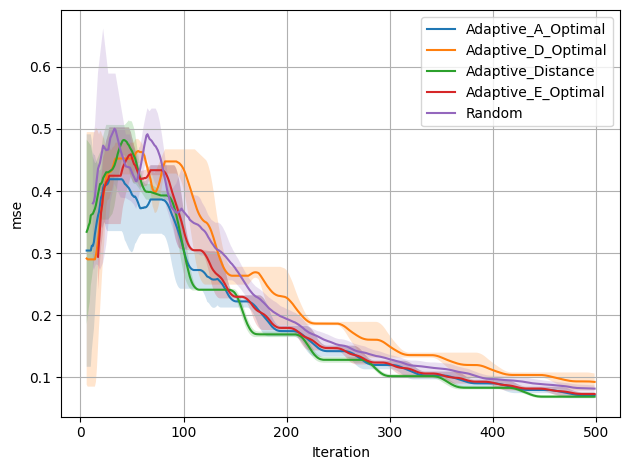

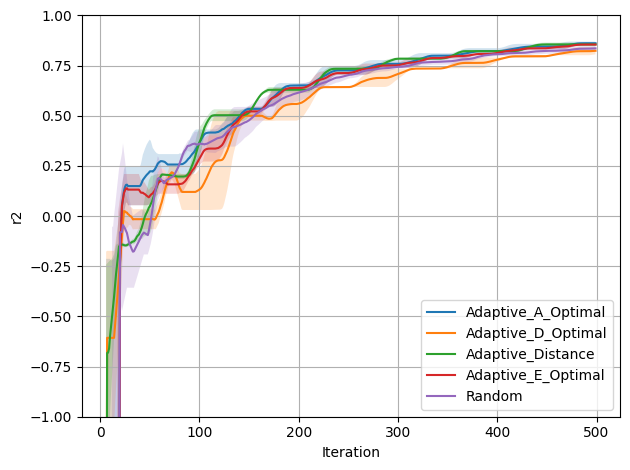

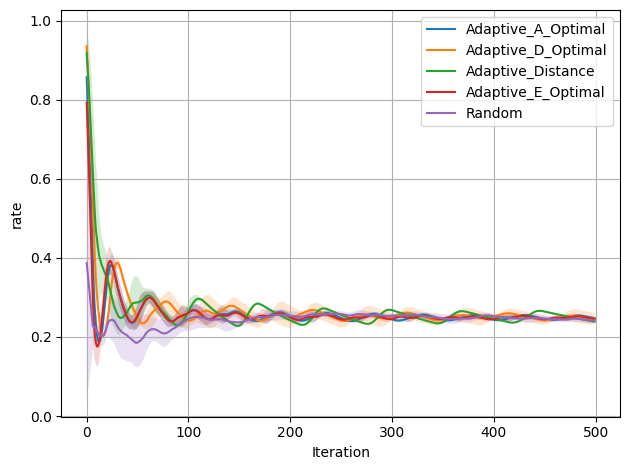

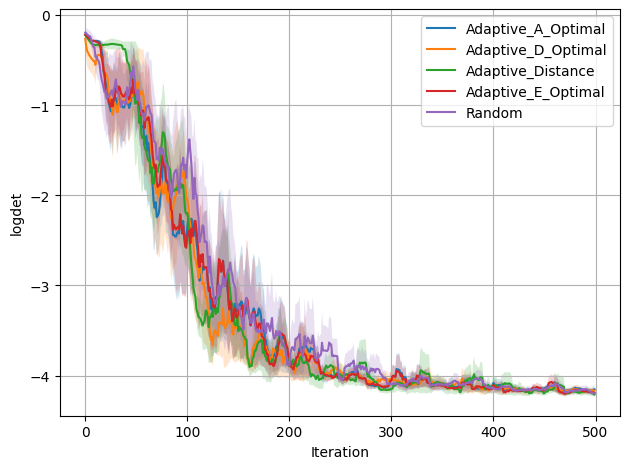

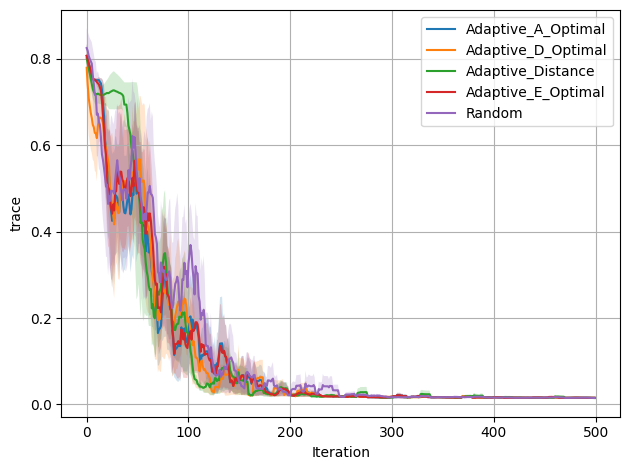

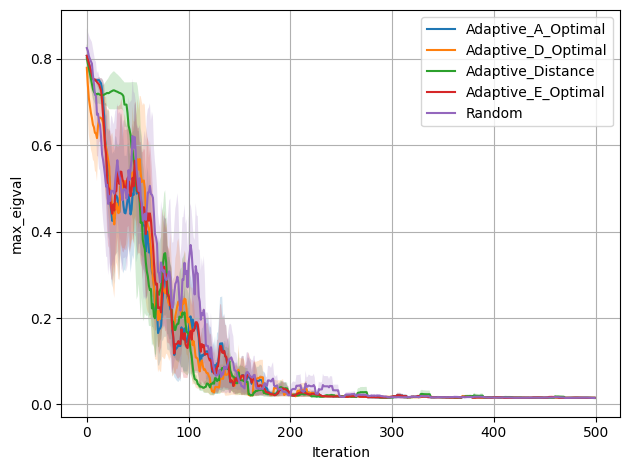

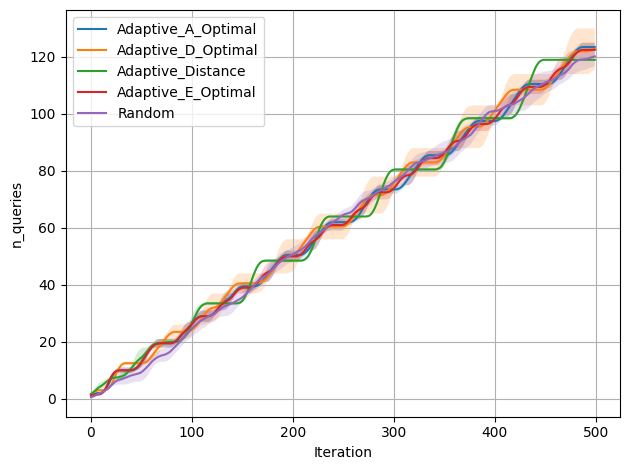

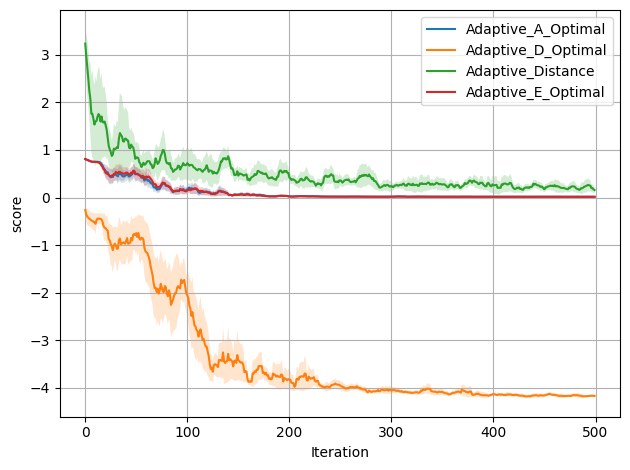

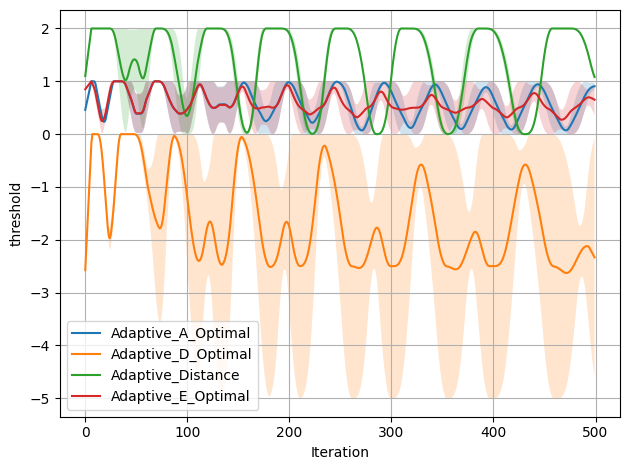

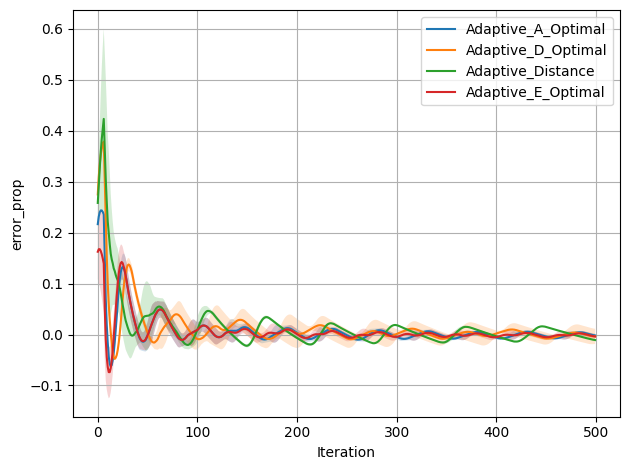

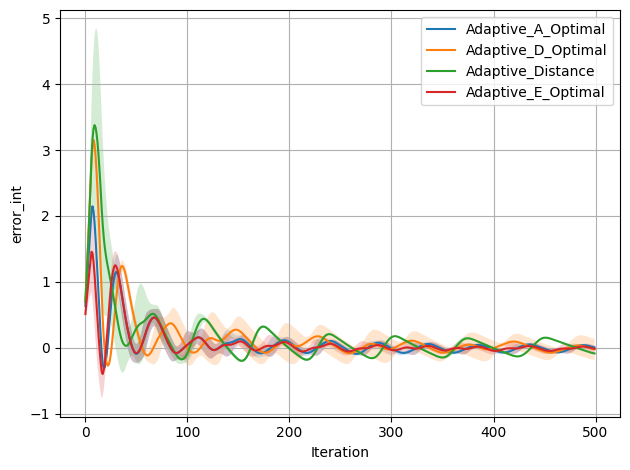

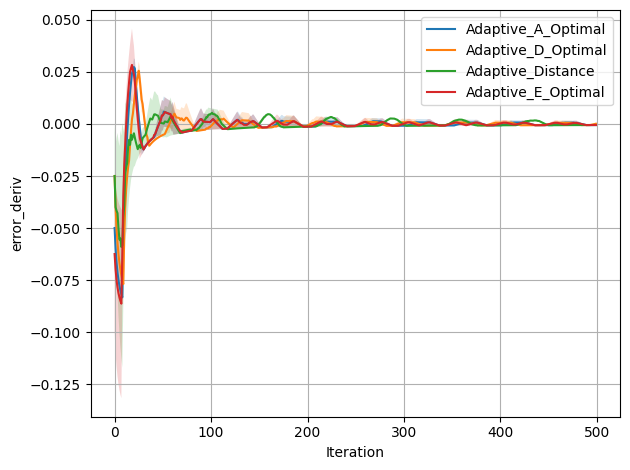

In [10]:
plot_metrics(metrics)

### Active learning with the Projectile simulation

In [11]:
metrics, summary = run_experiment(
    simulator=Projectile(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=500,
    adaptive_only=True,
    batch_size=None
)

Trial with seed 0


Adaptive_E_Optimal: 100%|██████████| 500/500 [01:38<00:00,  5.09it/s, mse=2.28e+7, r2=0.466, rate=0.566, logdet=11.4, trace=2.81e+3, max_eigval=2.78e+3, n_queries=283, score=2.78e+3, threshold=4.51e+3, error_prop=0.317, error_int=3.22, error_deriv=-0.00114]

Trial with seed 1



Adaptive_E_Optimal: 100%|██████████| 500/500 [01:00<00:00,  8.26it/s, mse=2.58e+7, r2=0.45, rate=0.56, logdet=10.1, trace=1.43e+3, max_eigval=1.41e+3, n_queries=280, score=1.41e+3, threshold=4.51e+3, error_prop=0.311, error_int=3.15, error_deriv=-0.00113]   


In [12]:
compute_statistics(summary)

mse_per_query                r2_per_query            \
                             mean            std         mean       std   
name                                                                      
Adaptive_A_Optimal   67393.664134    1431.239792     0.001588  0.000080   
Adaptive_E_Optimal   86495.646553    8208.666490     0.001627  0.000030   
Adaptive_D_Optimal  165009.676497   21862.791875     0.001769  0.000674   
Random              217131.999765  105996.444282     0.001643  0.001482   
Adaptive_Distance   255476.250904    8301.686570     0.000873  0.000705   

                   trace_per_query           logdet_per_query            \
                              mean       std             mean       std   
name                                                                      
Adaptive_A_Optimal        5.900740  3.491901         0.032598  0.004055   
Adaptive_E_Optimal        7.521685  3.417059         0.038244  0.002843   
Adaptive_D_Optimal       23.764620  9.174982         0.072524  0.004835   
Random                   37.615458  5.060386         0.101070  0.003884   
Adaptive_Distance        50.325485  7.517982         0.110126  0.009696   

                   max_eigval_per_query                 auc_mse                
                                   mean       std          mean           std  
name                                                                           
Adaptive_A_Optimal             5.834769  3.459241  9.341832e+09  1.001667e+09  
Adaptive_E_Optimal             7.433152  3.383011  8.669629e+09  8.512731e+08  
Adaptive_D_Optimal            23.487168  9.054846  5.469292e+09  1.406554e+09  
Random                        37.151451  5.096577  2.836627e+09  6.783562e+08  
Adaptive_Distance             49.599573  7.417038  4.008987e+09  2.142902e+09

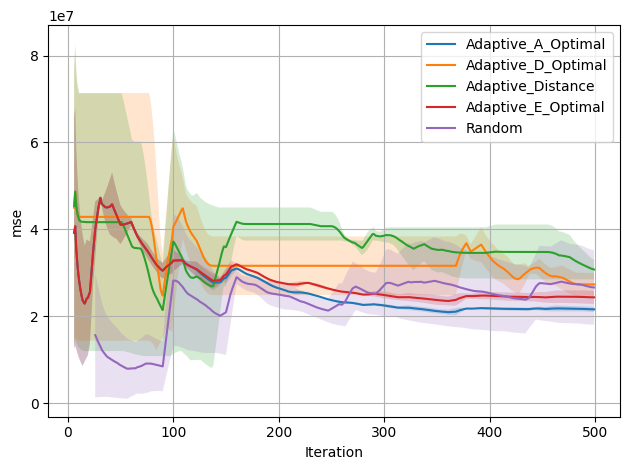

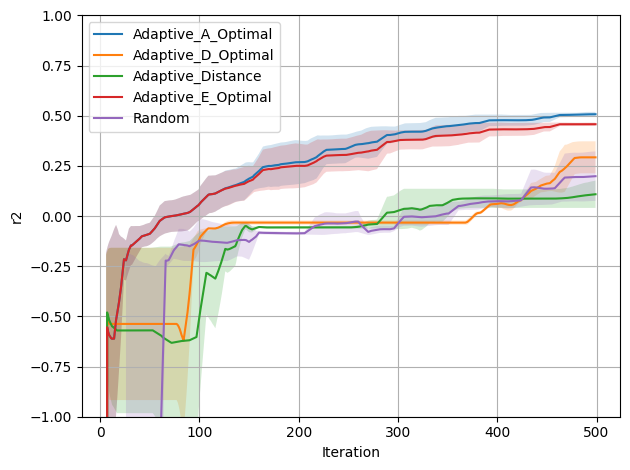

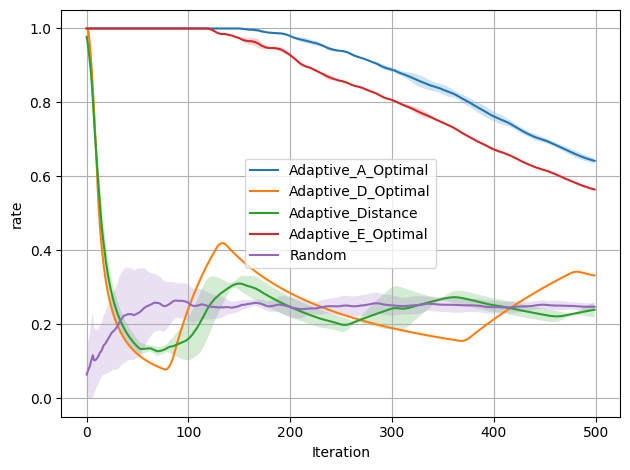

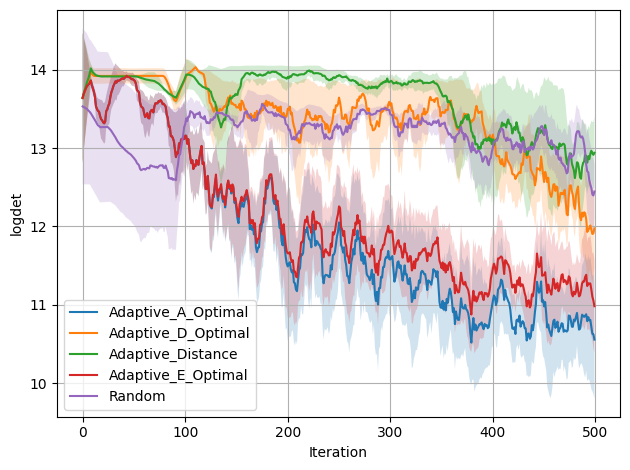

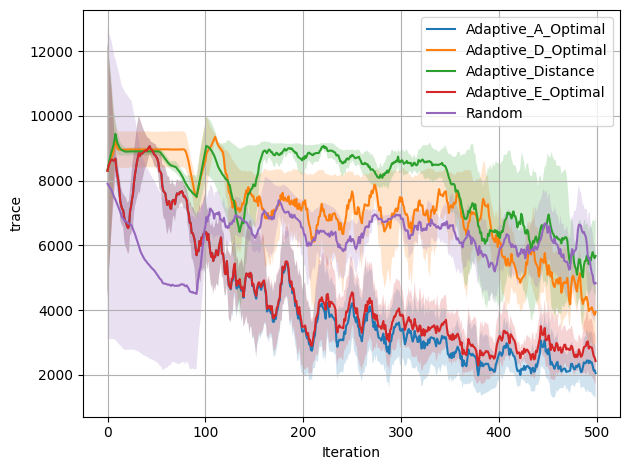

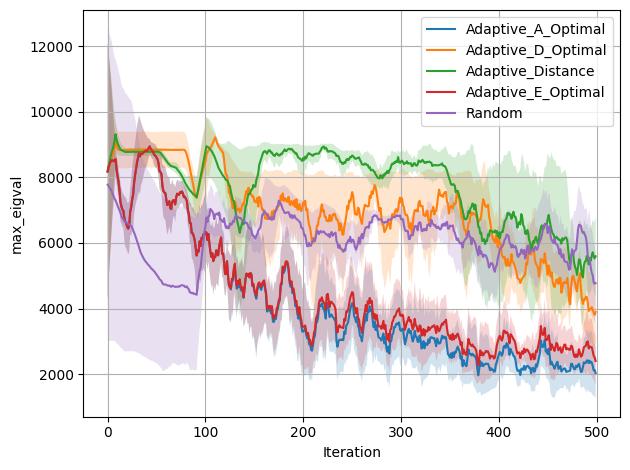

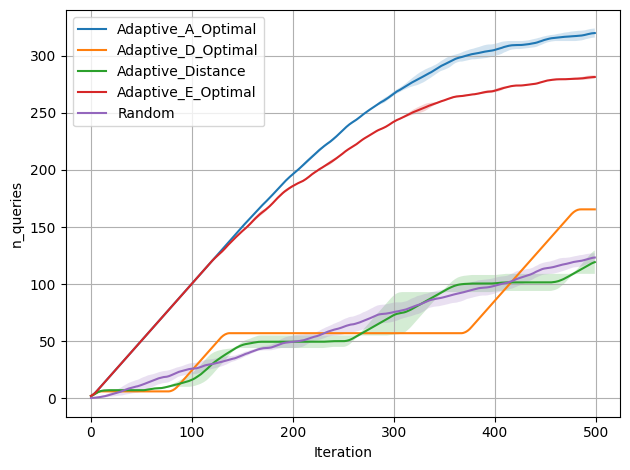

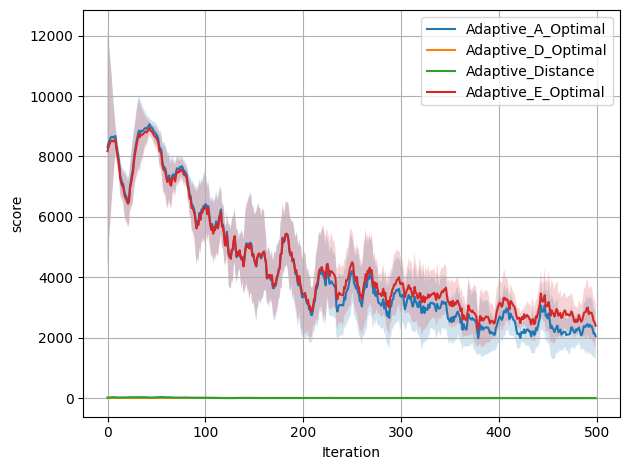

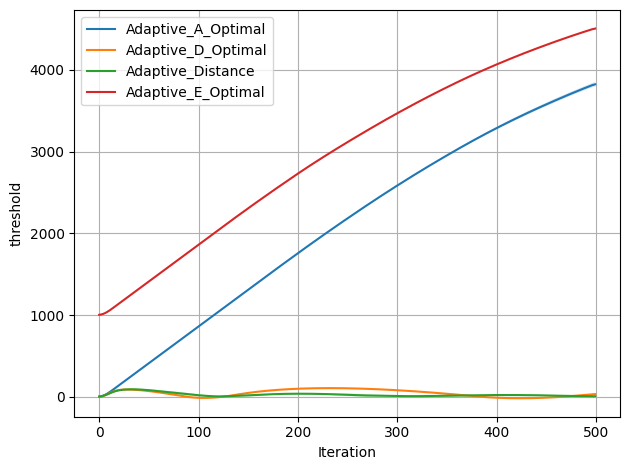

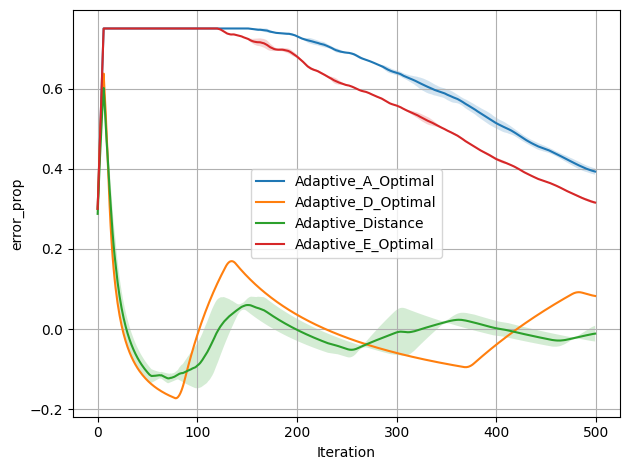

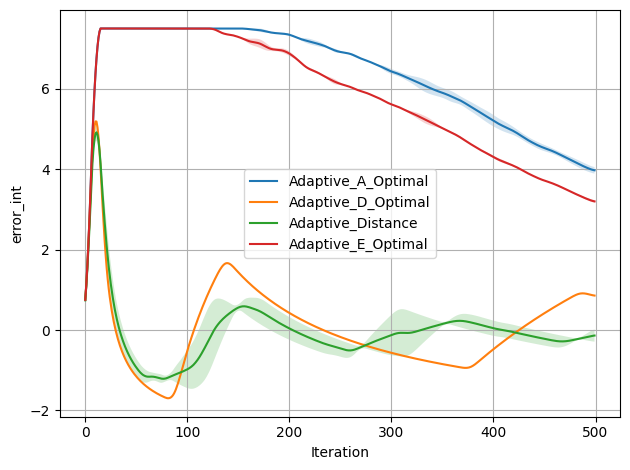

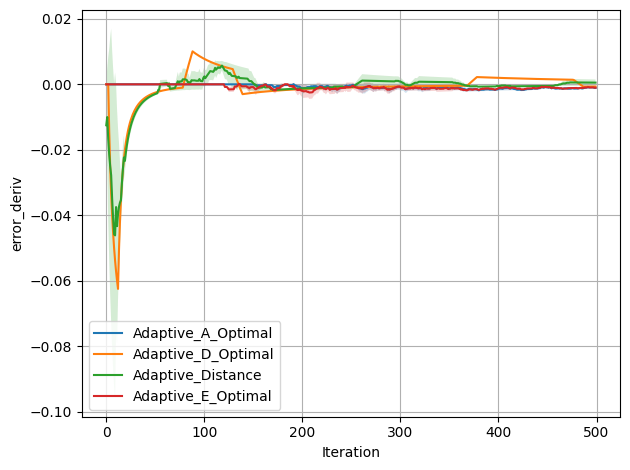

In [13]:
plot_metrics(metrics)

## Running an Active Learning Experiment in **batch mode**!

### Sinusoid

In [14]:
metrics, summary = run_experiment(
    simulator=Sin(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=1000,
    adaptive_only=True,
    batch_size=10
)

Trial with seed 0


Adaptive_E_Optimal (batches): 100%|██████████| 100/100 [00:04<00:00, 21.06it/s, mse=0.0356, r2=0.923, rate=0.27, logdet=-4.31, trace=0.0134, max_eigval=0.0134, n_queries=27, score=0.0134, threshold=1, error_prop=0.0227, error_int=0.294, error_deriv=-0.00278]       

Trial with seed 1



Adaptive_E_Optimal (batches): 100%|██████████| 100/100 [00:04<00:00, 22.40it/s, mse=0.0712, r2=0.857, rate=0.27, logdet=-4.27, trace=0.014, max_eigval=0.014, n_queries=27, score=0.014, threshold=1, error_prop=0.0227, error_int=0.294, error_deriv=-0.00278]         


In [15]:
compute_statistics(summary)

mse_per_query           r2_per_query            \
                            mean       std         mean       std   
name                                                                
Adaptive_A_Optimal      0.001430  0.000257     0.034014  0.000426   
Adaptive_D_Optimal      0.001555  0.000485     0.035337  0.001247   
Adaptive_E_Optimal      0.001979  0.000934     0.032954  0.001717   
Adaptive_Distance       0.002155  0.000386     0.041003  0.001010   
Random                  0.002693  0.002373     0.035144  0.005399   

                   trace_per_query           logdet_per_query            \
                              mean       std             mean       std   
name                                                                      
Adaptive_A_Optimal        0.000504  0.000015        -0.159179  0.001111   
Adaptive_D_Optimal        0.000544  0.000018        -0.163829  0.001298   
Adaptive_E_Optimal        0.000508  0.000016        -0.158850  0.001198   
Adaptive_Distance         0.000639  0.000001        -0.193827  0.000050   
Random                    0.000580  0.000160        -0.171844  0.041859   

                   max_eigval_per_query             auc_mse            
                                   mean       std      mean       std  
name                                                                   
Adaptive_A_Optimal             0.000504  0.000015  2.708355  0.498591  
Adaptive_D_Optimal             0.000544  0.000018  2.666937  0.798358  
Adaptive_E_Optimal             0.000508  0.000016  3.681404  1.674381  
Adaptive_Distance              0.000639  0.000001  2.494728  0.460284  
Random                         0.000580  0.000160  3.431246  1.454565

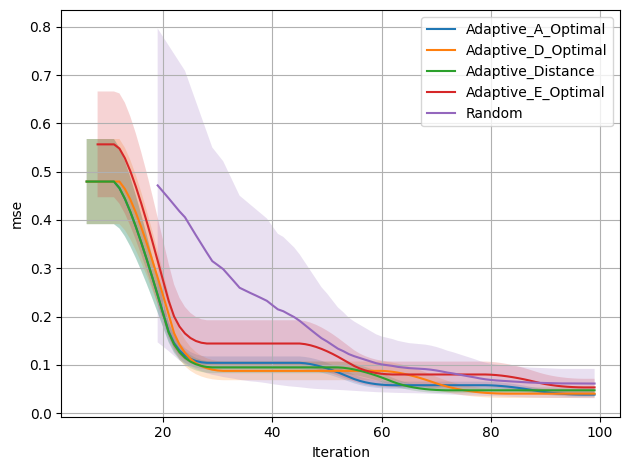

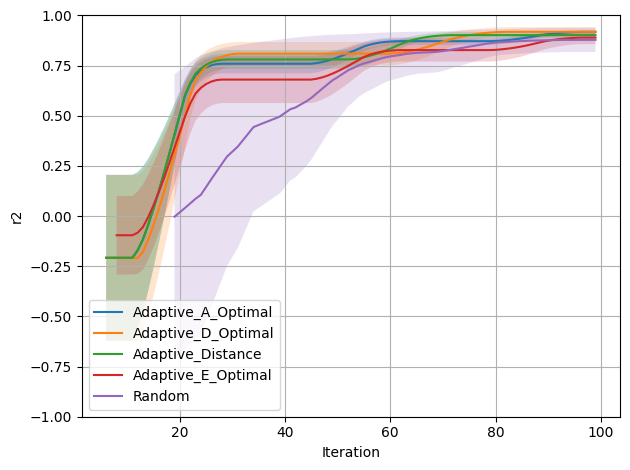

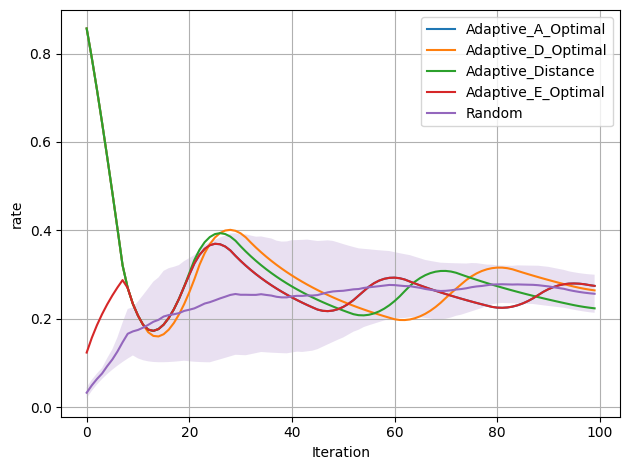

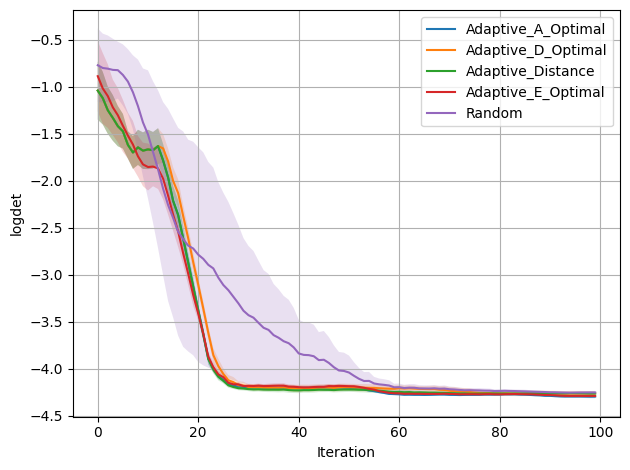

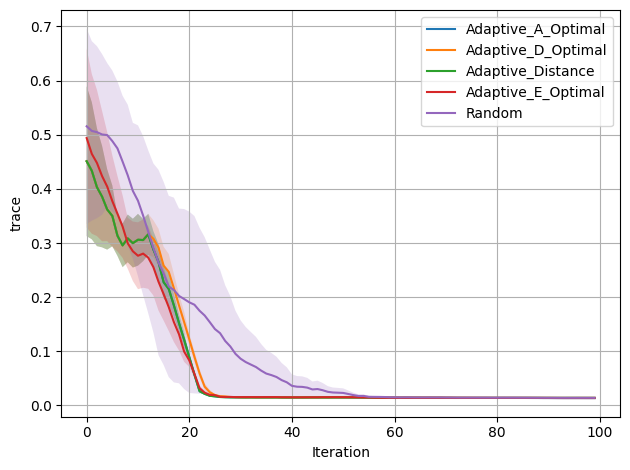

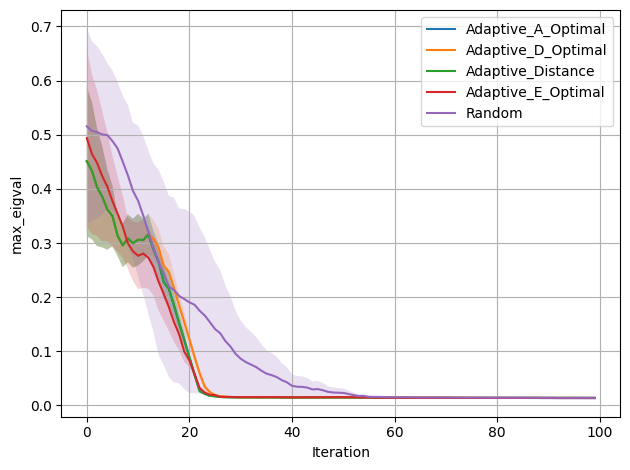

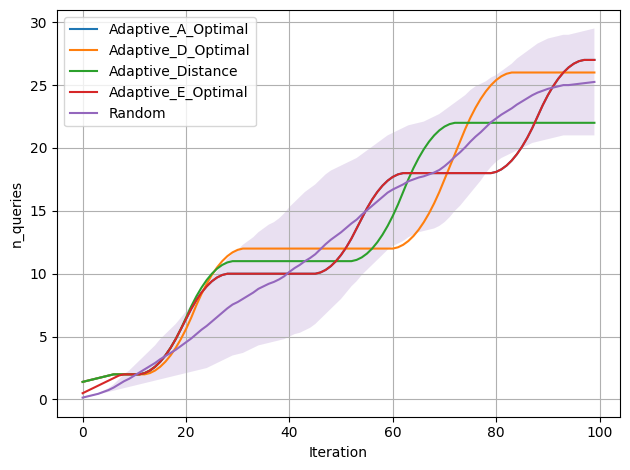

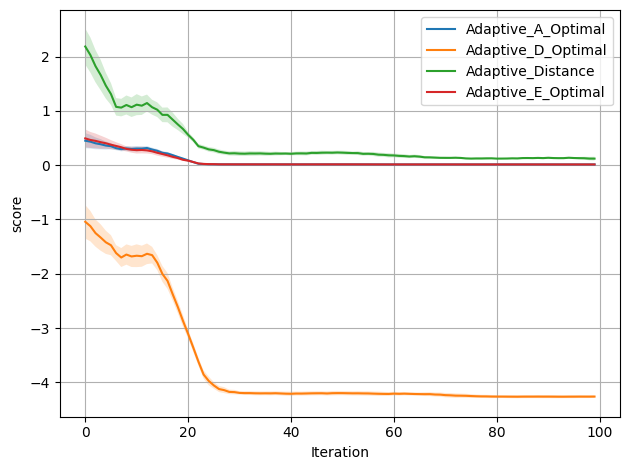

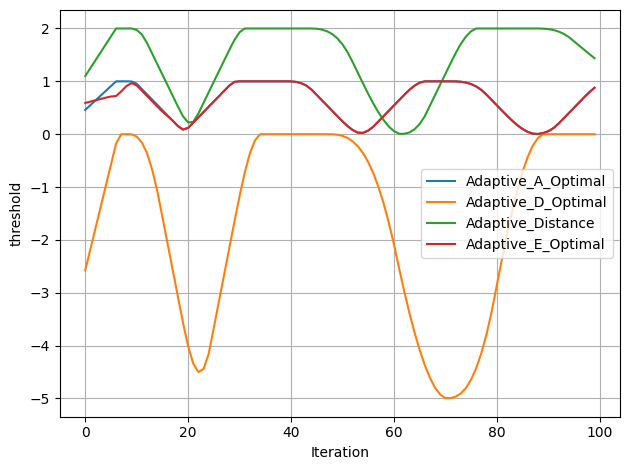

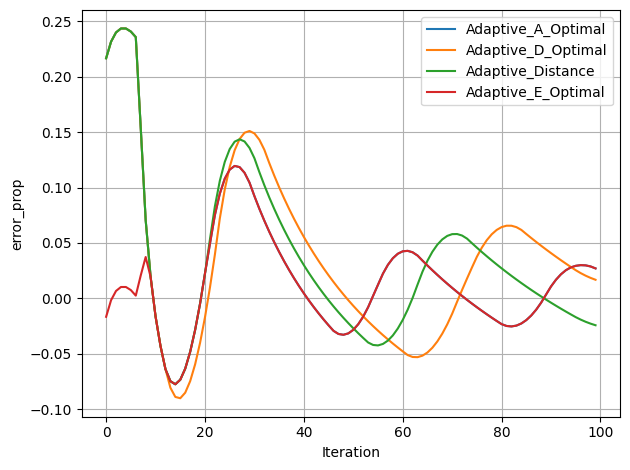

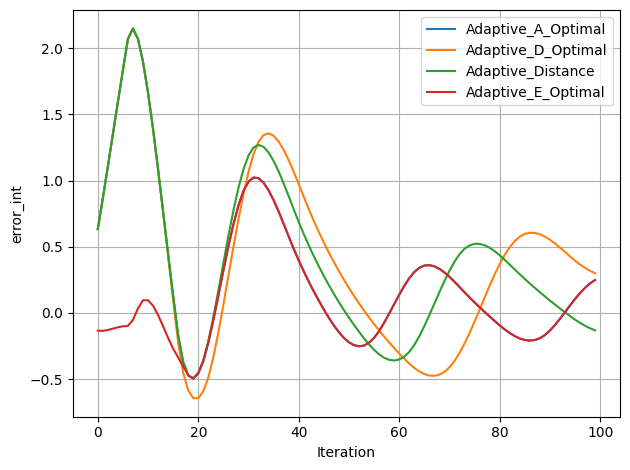

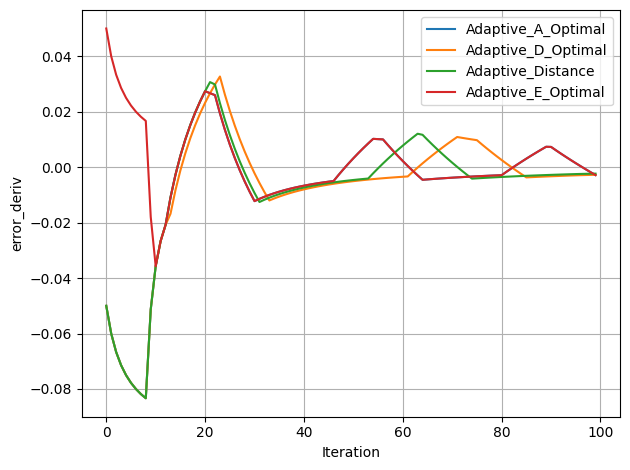

In [16]:
plot_metrics(metrics)

### Projectile

In [18]:
metrics, summary = run_experiment(
    simulator=Projectile(),
    seeds=[0, 1],
    n_initial_samples=5,
    n_stream_samples=1000,
    adaptive_only=True,
    batch_size=10
)

Trial with seed 0


Adaptive_E_Optimal (batches): 100%|██████████| 100/100 [01:32<00:00,  1.08it/s, mse=7.57e+6, r2=0.808, rate=1, logdet=13.8, trace=8.27e+3, max_eigval=8.16e+3, n_queries=100, score=8.16e+3, threshold=1857.25, error_prop=0.75, error_int=7.5, error_deriv=0]

Trial with seed 1



Adaptive_E_Optimal (batches): 100%|██████████| 100/100 [01:29<00:00,  1.12it/s, mse=6.88e+6, r2=0.822, rate=1, logdet=13.9, trace=8.79e+3, max_eigval=8.66e+3, n_queries=100, score=8.66e+3, threshold=1857.25, error_prop=0.75, error_int=7.5, error_deriv=0]


In [19]:
compute_statistics(summary)

mse_per_query                r2_per_query            \
                            mean            std         mean       std   
name                                                                     
Adaptive_E_Optimal  7.226045e+04    4910.868839     0.008149  0.000099   
Adaptive_A_Optimal  7.246368e+04    5015.120301     0.008145  0.000100   
Adaptive_Distance   6.658168e+05   54079.639877     0.016005  0.000120   
Random              7.081753e+05  172529.395814     0.017845  0.004058   
Adaptive_D_Optimal  1.170414e+06   57542.839557     0.018246  0.001624   

                   trace_per_query            logdet_per_query            \
                              mean        std             mean       std   
name                                                                       
Adaptive_E_Optimal       85.303052   3.621290         0.138184  0.000718   
Adaptive_A_Optimal       85.812048   2.151912         0.137889  0.001393   
Adaptive_Distance       110.189843  33.569507         0.350230  0.030435   
Random                  139.138850  98.816539         0.490334  0.210429   
Adaptive_D_Optimal      197.113431   8.900926         0.508082  0.000052   

                   max_eigval_per_query                  auc_mse                
                                   mean        std          mean           std  
name                                                                            
Adaptive_E_Optimal            84.099611   3.583415  1.805136e+09  1.686049e+08  
Adaptive_A_Optimal            84.646963   2.013330  1.805981e+09  1.694973e+08  
Adaptive_Distance            109.132263  33.323407  1.044083e+09  1.993828e+08  
Random                       137.368100  97.364876  4.838590e+08  3.008862e+08  
Adaptive_D_Optimal           194.972449   8.825465  9.516407e+08  1.357792e+08

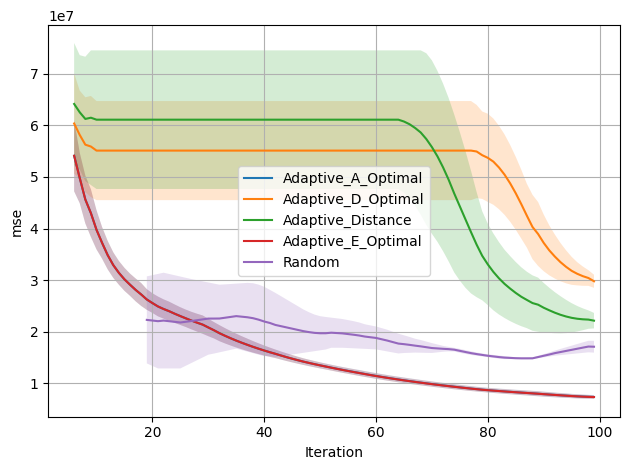

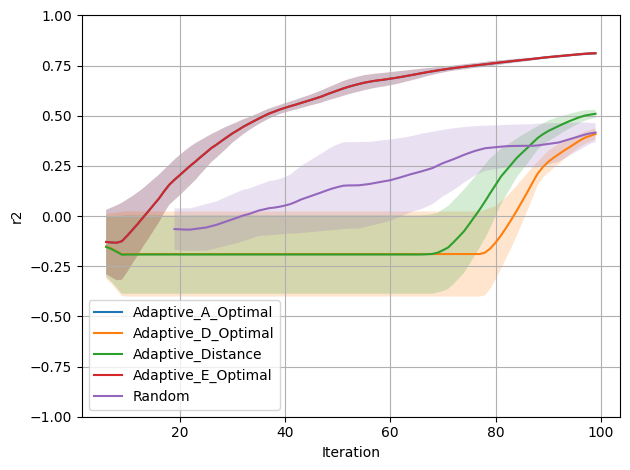

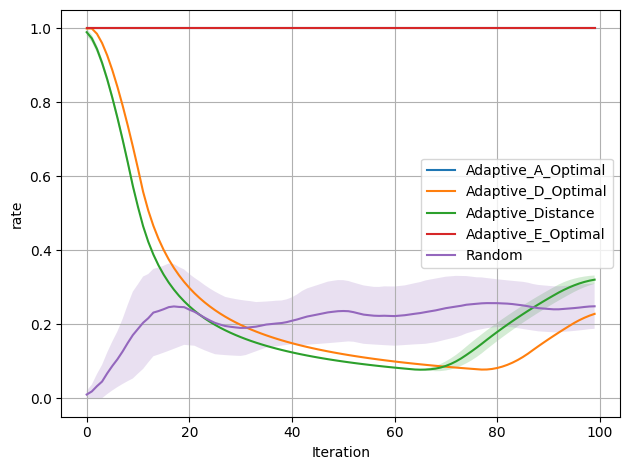

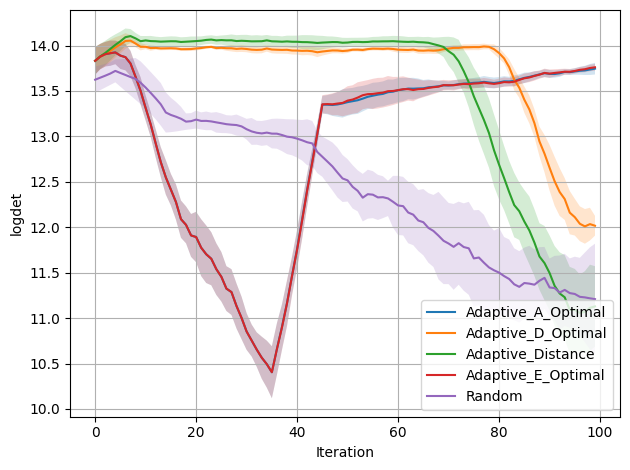

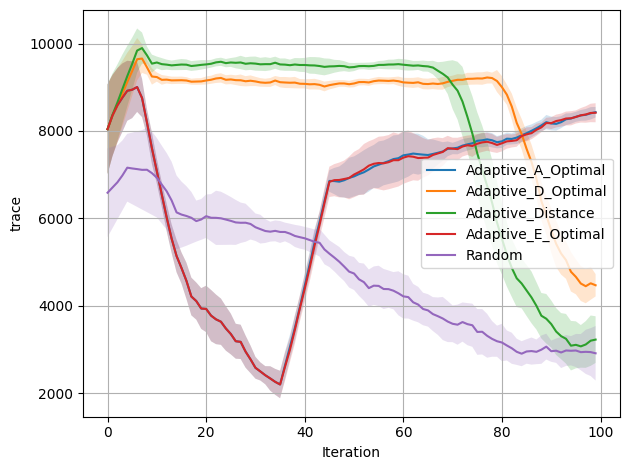

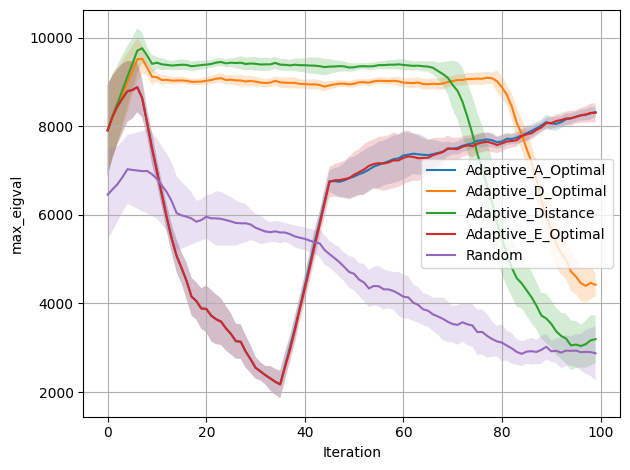

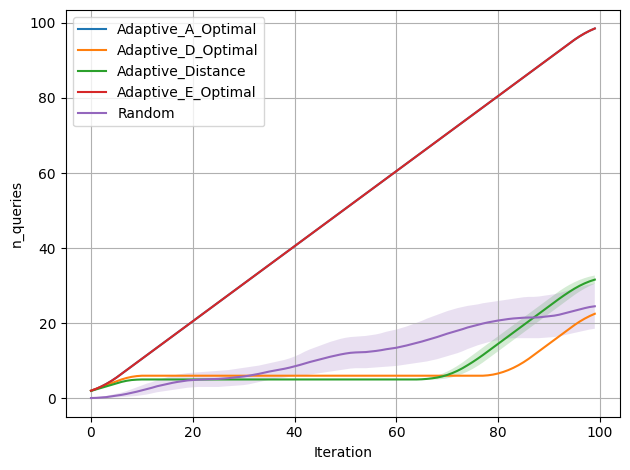

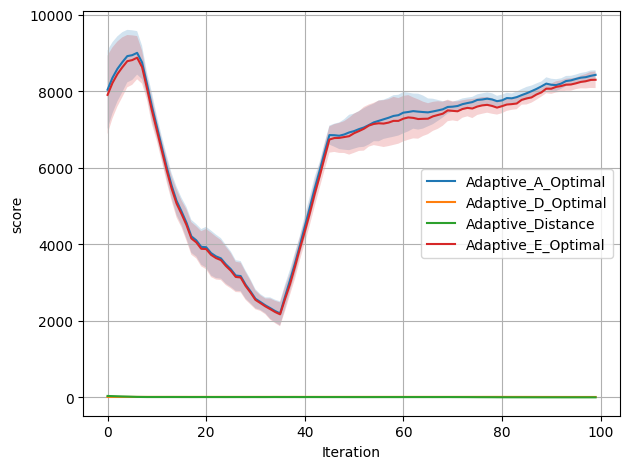

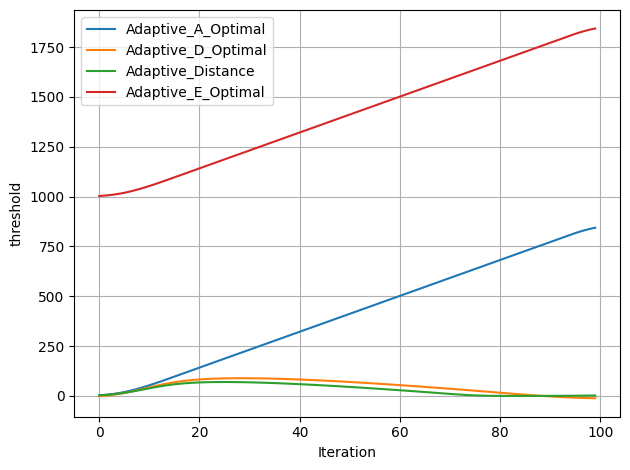

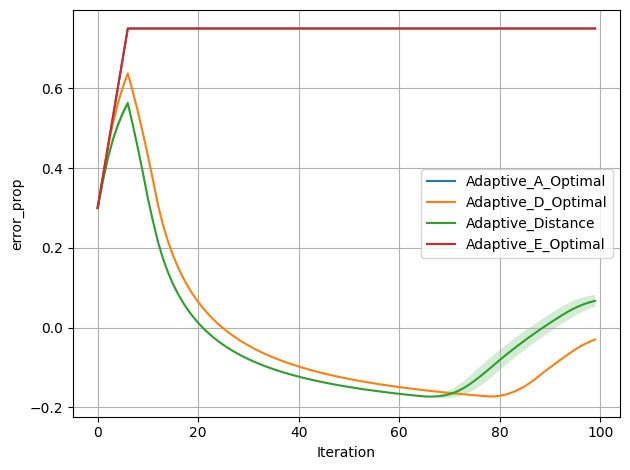

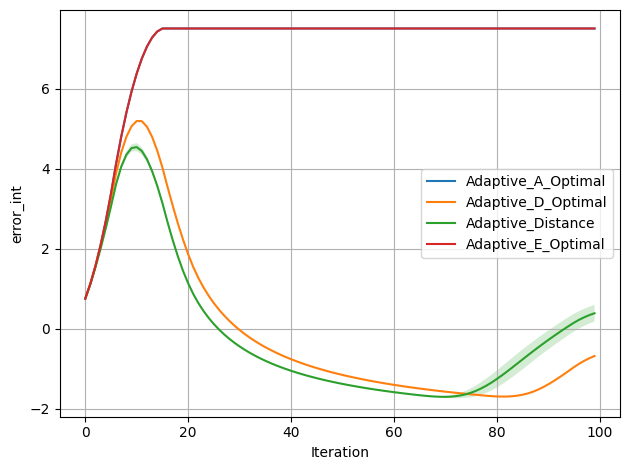

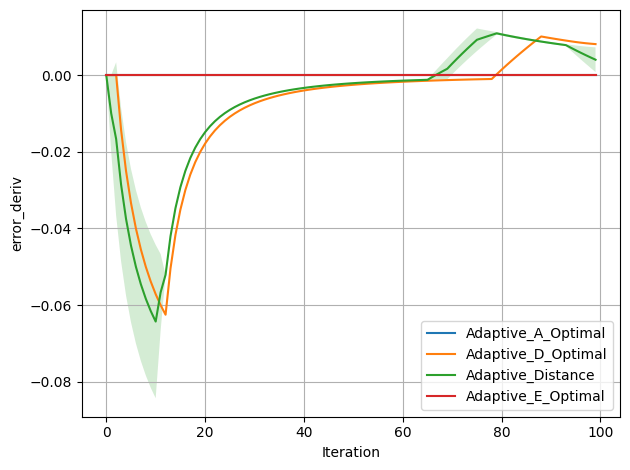

In [20]:
plot_metrics(metrics)